# 🧱 ETL Pipeline from Scratch
---

This project demonstrates a basic ETL (Extract, Transform, Load) pipeline, a core concept in data engineering. It showcases how to extract raw data, transform it into structured form, and load it into a new format or schema using Pandas.

We work with a CSV file containing movie metadata and apply transformations to produce normalized data tables, suitable for analytics or database use.

**This is a fully open-source example using only Pandas, with no external ETL frameworks or orchestration tools.**

An ETL pipeline (Extract, Transform, Load) is a fundamental data engineering process used to move data from one or more sources into a centralized data store, such as a data warehouse. Once the data is loaded, it becomes available for:

- Business intelligence and reporting

- Statistical analysis

- Machine learning models

- Backend services and frontend applications

This pipeline ensures that raw data is structured, cleaned, and ready for any data-driven application.

###  🔄 The ETL Process: Step-by-Step
The ETL process is divided into three core stages:

1. Extract – Gather raw data from multiple sources.
Data can come from homogeneous (similar) or heterogeneous (different) data sets.

- Common practice: merge data into a unified format

- Perform validation to ensure data quality

- If validation fails, data is excluded from the pipeline

2. Transform – Clean and prepare the data for storage.
At this stage, transformation rules are applied, such as:

- Data type conversions

- Normalization

- Filtering and enrichment

- Data cleansing (removal of invalid or redundant data)

3. Load – Store the processed data in the destination

- The final step is loading data into a data warehouse, data mart, or database

- Efficient loading strategies ensure that the system stays performant and scalable

<div style="text-align:center;">
    <img src="https://learn.microsoft.com/en-us/azure/architecture/data-guide/images/etl.png" width="500" align>
</div>


## Part 1. ETL

---
### 1.1. Extract

📂 Loading the Dataset
We’ll begin by loading the dataset `movies.csv`, which contains information about movies and their genres.

Dataset columns:

- `movieId` — unique identifier for each movie

- `title` — the title of the movie

- `genres` — a list of genres associated with each movie

<div>
    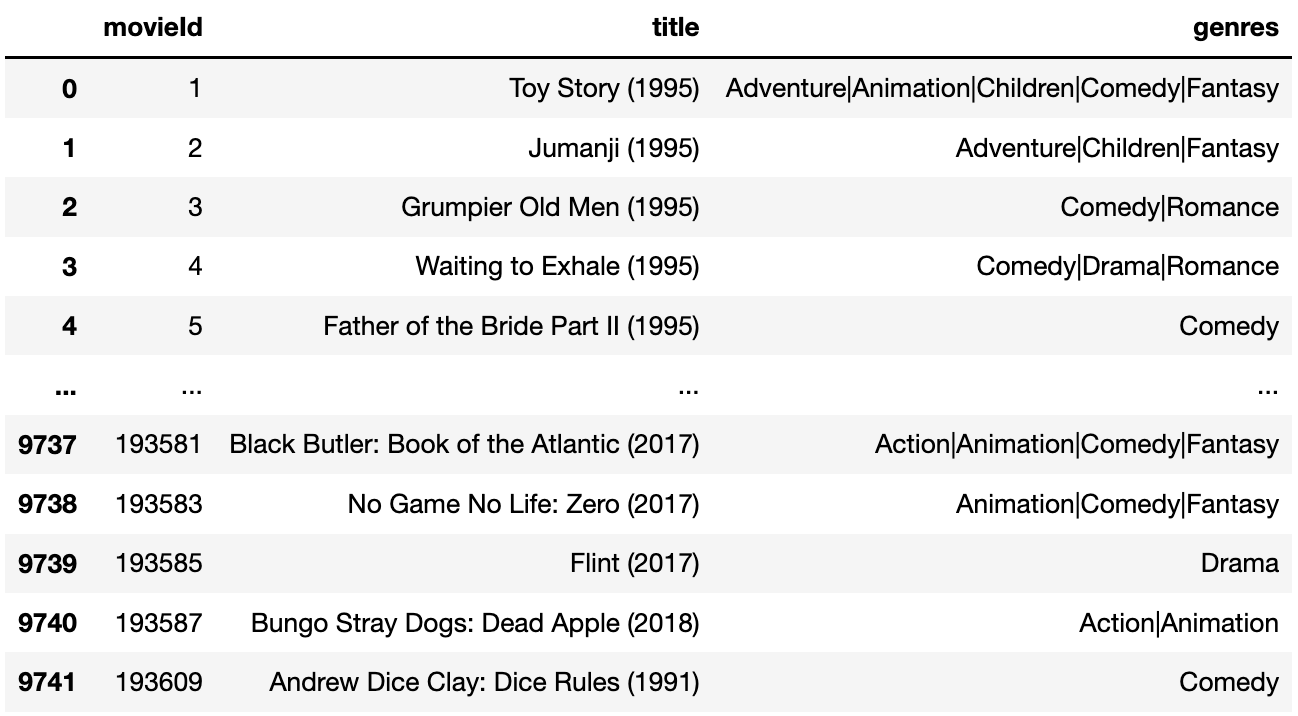
</div>

In [1]:
import pandas as pd

In [2]:
# Load the CSV file into a DataFrame
df = pd.read_csv('movies.csv')

In [3]:
# Display the first few rows of the dataset
df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


---
### 1.2. Data Transformation
After loading the dataset, we will split it into **three separate tables** to represent a more normalized structure, suitable for analytical tasks or database ingestion.

- `Movies Table` — basic movie metadata

- `Genres Table` — a list of all unique genres

- `Connection Table` — a mapping between movies and their genres

### 🎬 1.2.1. Movies Table
This table will contain:

- `id` — the unique movie ID

- `title` — the name of the movie

- `year` — the release year (extracted from the title)

We will extract the year from the movie title and separate it into a new column.

<div>
    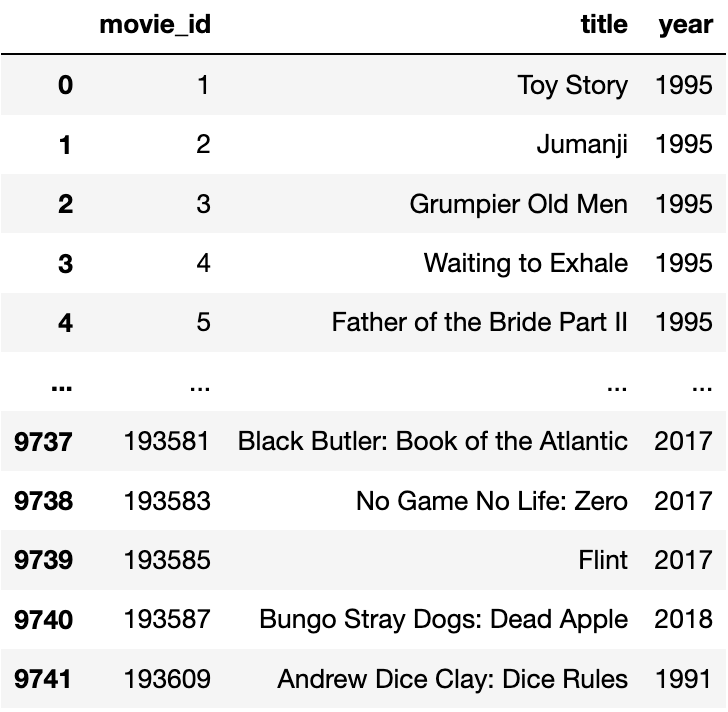
</div>

In [4]:
LST_movies = []
LST_titles = []

In [5]:
# Split title into movie name and year
for i in range(len(df['title'])):
    title = df['title'][i].split()
    LST_movies.append(title.pop(-1).replace('(', '').replace(')', ''))  # Extract year
    LST_titles.append(' '.join(title))  # Remaining part is the movie title

In [6]:
# Create a new DataFrame
df_movies = pd.DataFrame({
    'id': df['movieId'],
    'title': LST_titles,
    'year': LST_movies
})

In [7]:
# Display the result
df_movies.head()

,id,title,year
0,1,Toy Story,1995
1,2,Jumanji,1995
2,3,Grumpier Old Men,1995
3,4,Waiting to Exhale,1995
4,5,Father of the Bride Part II,1995


#### 🎭 1.2.2. Genres Table
In this step, we extract all unique genres from the dataset and create a separate `Genres` table.

This table will include:

- `id` — a unique numeric identifier

- `name` — the name of the genre (e.g., Action, Comedy, Drama)

We will:

- Split the `genres` column by delimiter `|`

- Collect all unique genre names

- Sort them alphabetically

- Assign an ID to each genre

<div>
    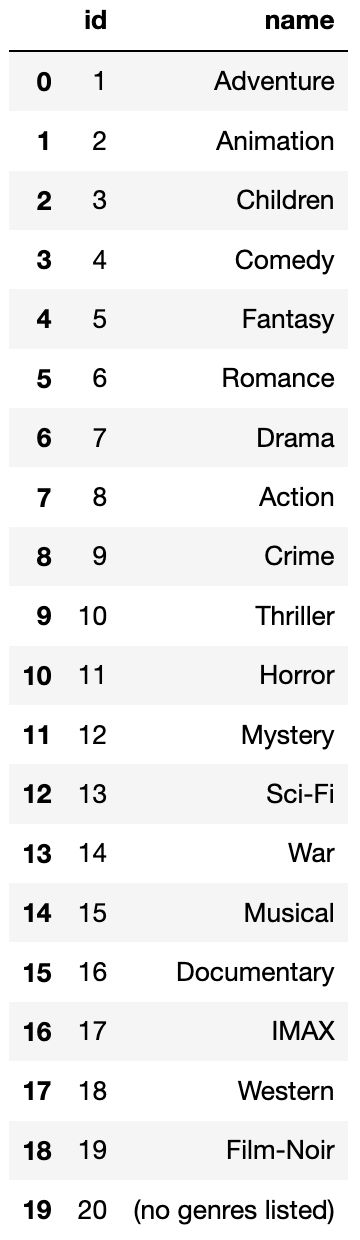
</div>

In [8]:
genres = []
LST_genres = []

In [9]:
# Split genres into lists
for i in range(len(df)):
    genres.append(df.iloc[i, 2].split('|'))

# Flatten the list of lists into a single list of genre names
for i in genres:
    for j in i:
        LST_genres.append(j)

In [10]:
# Remove duplicates and sort
LST_genres = list(set(LST_genres))
LST_genres.sort()

In [11]:
# Create the genres DataFrame
df_genres = pd.DataFrame({
    'id': [i + 1 for i in range(len(LST_genres))],
    'name': LST_genres
})

In [12]:
# Display the result
df_genres.head()

,id,name
0,1,(no genres listed)
1,2,Action
2,3,Adventure
3,4,Animation
4,5,Children


#### 🔗 1.2.3. Connection Table
The final step in our data transformation process is to build a `Connection Table`

This table models the `many-to-many relationship` between movies and genres and contains:

- `movie_id` — a reference to the movie

- `genre_id` — a reference to the genre

We will iterate through the original dataset, map genres to their IDs, and assign corresponding movie IDs.

<div>
    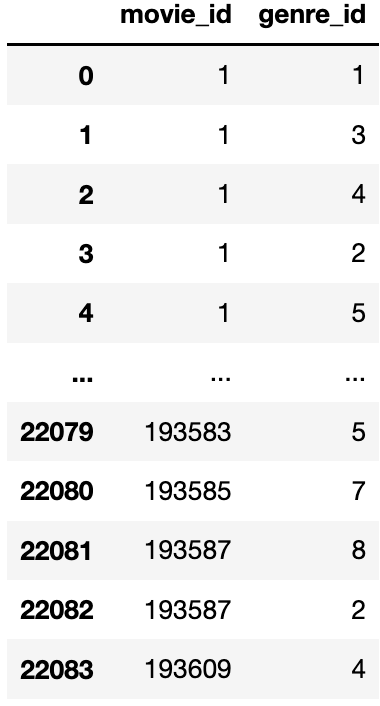
</div>

In [13]:
new_dict = {}

In [14]:
# Create a dictionary: movieId -> list of genre names
for i in range(len(df)):
    new_dict[df.iloc[i, 0]] = df.iloc[i, 2].split('|')

In [15]:
keys = []
key_genre = []

In [16]:
# Flatten the dictionary into a list of movie-genre pairs
for i in new_dict.keys():
    for j in new_dict[i]:
        keys.append(float(i))       # movie_id
        key_genre.append(j)         # genre name

In [17]:
# Map genre names to genre IDs
genre_number = []

for i in range(len(key_genre)):
    for j in range(len(df_genres)):
        if key_genre[i] == df_genres.iloc[j, 1]:
            genre_number.append(float(df_genres.iloc[j, 0]))

In [18]:
# Create the connection DataFrame
df_connection = pd.DataFrame({
    'movie_id': keys,
    'genre_id': genre_number
})

In [19]:
# Display the result
df_connection.head()

,movie_id,genre_id
0,1.0,3.0
1,1.0,4.0
2,1.0,5.0
3,1.0,6.0
4,1.0,10.0


---
### 🧩 1.3. Load
In this final step, we simulate the "`Load`" phase of the ETL pipeline by pushing our cleaned and structured data into a `SQLite database.`

We'll first preview the three resulting tables:

In [20]:
# Preview the Movies table
df_movies.head()

,id,title,year
0,1,Toy Story,1995
1,2,Jumanji,1995
2,3,Grumpier Old Men,1995
3,4,Waiting to Exhale,1995
4,5,Father of the Bride Part II,1995


In [21]:
# Preview the Genres table
df_genres.head()

,id,name
0,1,(no genres listed)
1,2,Action
2,3,Adventure
3,4,Animation
4,5,Children


In [22]:
# Preview the Connection table
df_connection.head()

,movie_id,genre_id
0,1.0,3.0
1,1.0,4.0
2,1.0,5.0
3,1.0,6.0
4,1.0,10.0


Now we will define the database schema and load the data into SQLite:

- `movies`: contains movie ID, title, and release year

- `genres`: contains genre ID and name

- `movie_genres`: maps each movie to one or more genres

#### image: Database Schema


<div>
    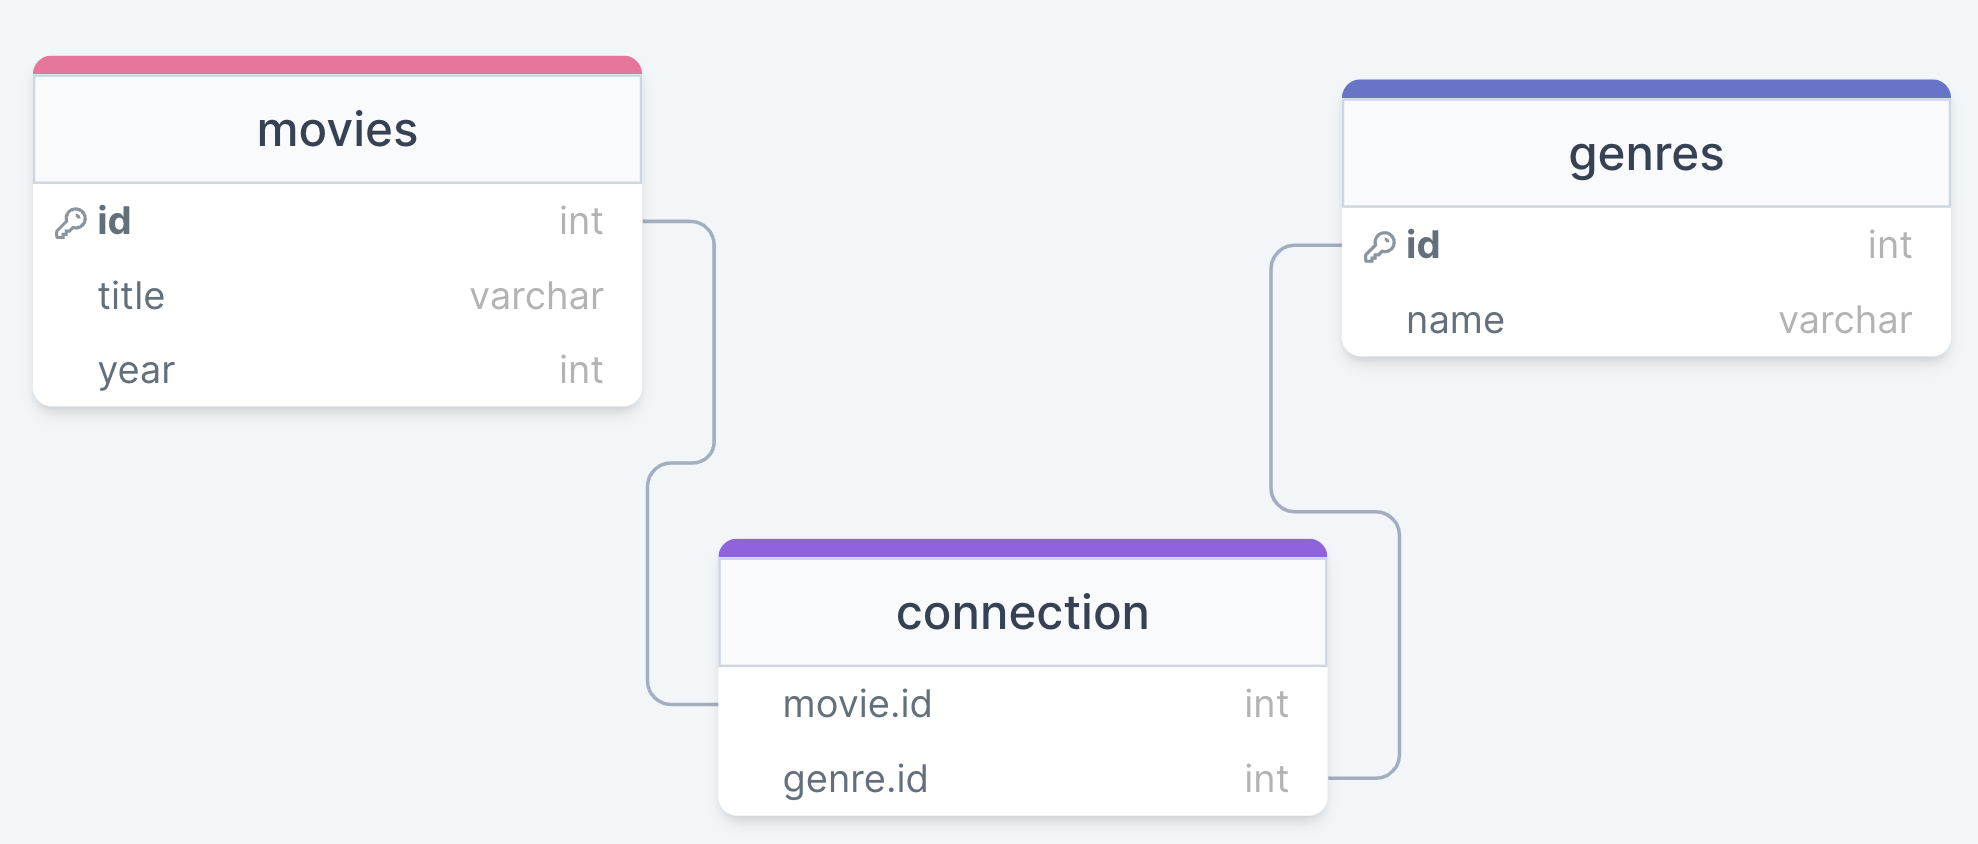
</div>

---
### 🗃️ Create and Populate SQLite Tables Manually
Instead of using to_sql, we can also manually define the database schema and insert data row by row using SQL queries. This gives us full control over the data structure and constraints.

#### 📐 Step 1: Connect to the SQLite Database

In [23]:
import sqlite3

In [24]:
# Connect to the database (or create it if it doesn't exist)
conn = sqlite3.connect("movies_etl.db")
c = conn.cursor()

#### 🧱 Step 2: Create Tables

In [25]:
# Create the 'movies' table
c.execute("""
    CREATE TABLE IF NOT EXISTS movies (
        id INTEGER PRIMARY KEY, 
        title VARCHAR,
        year INTEGER
    )
""")
conn.commit()

In [26]:
# Create the 'genres' table
c.execute("""
    CREATE TABLE IF NOT EXISTS genres (
        id INTEGER PRIMARY KEY, 
        name VARCHAR
    )
""")
conn.commit()

In [27]:
# Create the 'connection' (junction) table
c.execute("""
    CREATE TABLE IF NOT EXISTS connection (
        movie_id INTEGER, 
        genre_id INTEGER,
        FOREIGN KEY(movie_id) REFERENCES movies(id),
        FOREIGN KEY(genre_id) REFERENCES genres(id)
    )
""")
conn.commit()

### 📥 Step 3: Insert Data into Tables


Insert into movies table:

In [28]:
for i, row in df_movies.iterrows():
    movie_id = row['id']
    name = row['title']
    year = row['year']
    
    c.execute("""
        INSERT INTO movies(id, title, year)
        VALUES(?, ?, ?)
    """, (movie_id, name, year))
    
    conn.commit()

Insert into genres table:

In [29]:
for i, row in df_genres.iterrows():
    genre_id = row['id']
    name = row['name']
    
    c.execute("""
        INSERT INTO genres(id, name)
        VALUES(?, ?)
    """, (genre_id, name))
    
    conn.commit()

Insert into connection table:

In [30]:
for i, row in df_connection.iterrows():
    id_movie = row['movie_id']
    id_genre = row['genre_id']
    
    c.execute("""
        INSERT INTO connection(movie_id, genre_id)
        VALUES(?, ?)
    """, (id_movie, id_genre))
    
    conn.commit()

💡 This completes the ETL process: we’ve extracted raw data, transformed it into structured tables, and loaded it into a relational database ready for querying.

---
### 🧪 Querying the Database
Now that all tables are loaded into the SQLite database, we can query the data using SQL to verify the structure and explore relationships.

**Here’s an example query to list all movies and their genres:**

In [31]:
# Reconnect if needed
conn = sqlite3.connect("movies_etl.db")
c = conn.cursor()

# SQL query: join movies with genres via the connection table
query = """
SELECT 
    m.title || ' (' || m.year || ')' AS movie_title,
    g.name AS genre
FROM 
    movies m
JOIN 
    connection c ON m.id = c.movie_id
JOIN 
    genres g ON g.id = c.genre_id
ORDER BY 
    movie_title
LIMIT 10;
"""

# Execute and display results
result = c.execute(query).fetchall()

for row in result:
    print(row)

(' (Cosmos)', '(no genres listed)')
(' (Moonlight)', 'Drama')
(' (Paterson)', '(no genres listed)')
("'71 (2014)", 'Action')
("'71 (2014)", 'Drama')
("'71 (2014)", 'Thriller')
("'71 (2014)", 'War')
("'Hellboy': The Seeds of Creation (2004)", 'Action')
("'Hellboy': The Seeds of Creation (2004)", 'Adventure')
("'Hellboy': The Seeds of Creation (2004)", 'Comedy')
